# X Batcher Demo Notebook 

Author: Cindy Chiao
Last Modified: Oct 8, 2021

## What is X Bathcer 
Xbatcher is a small library for iterating xarray DataArrays in batches. The goal is to make it easy to feed xarray datasets to machine learning libraries such as Keras. 

## What is included in this notebook 
* showcase current abilities with example data 
* brief discussion of current development track and ideas for future work 

In [1]:
import xarray as xr
import xbatcher

## Example Data

In [2]:
# load an example GCM historical data for 3 variables 
ds = xr.open_zarr('data/ACCESS-ESM1-5.historical.day.20140101.20140301.zarr')
ds.attrs = {}

In [3]:
# inspect the dataset 
ds

<xarray.Dataset>
Dimensions:  (lat: 145, lon: 192, time: 60)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 2014-01-01T12:00:00 ... 2014-03-01T12:00:00
Data variables:
    pr       (time, lat, lon) float32 dask.array<chunksize=(60, 145, 192), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(60, 145, 192), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(60, 145, 192), meta=np.ndarray>

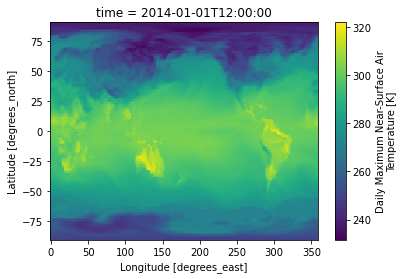

In [4]:
# plot the first time dimension 
ds.isel(time=0).tasmax.plot()

## Batch Generation

In [5]:
# the BatchGenerator function can operate on multiple variables at the same time 
# input_dims takes a dictionary specifying the size of the inputs in each dimension
# for example, {'time': 10} means that each of the input sample will have 10 time points, while all other dimensions are flattened to a "sample" dimension

n_timepoint_in_each_sample = 10
bgen = xbatcher.BatchGenerator(
    ds=ds, 
    input_dims={'time': n_timepoint_in_each_sample},
)

n_batch = 0
for batch in bgen:
    n_batch += 1
batch

<xarray.Dataset>
Dimensions:  (sample: 27840, time: 10)
Coordinates:
  * time     (time) datetime64[ns] 2014-02-20T12:00:00 ... 2014-03-01T12:00:00
  * sample   (sample) MultiIndex
  - lat      (sample) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
  - lon      (sample) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Data variables:
    pr       (sample, time) float32 7.446e-07 1.914e-06 ... 2.159e-06 1.933e-06
    tasmax   (sample, time) float32 234.7 235.1 234.7 ... 237.8 238.2 239.1
    tasmin   (sample, time) float32 228.6 234.5 226.6 ... 236.8 236.7 234.0

In [6]:
# we can verify that the outputs have the expected shapes 

# there are 60 time points in our input dataset, we're asking 10 timepoints in each batch, thus expecting 6 batches 
expected_n_batch = len(ds.time) / n_timepoint_in_each_sample
print(f'Expecting {expected_n_batch} batches, getting {n_batch} batches')

# there are 145 lat points and 192 lon points, thus we're expecting 145 * 192 = 27840 samples in a batch
expected_batch_size = len(ds.lat) * len(ds.lon)
print(f'Expecting {expected_batch_size} samples per batch, getting {len(batch.sample)} samples per batch')

Expecting 6.0 batches, getting 6 batches
Expecting 27840 samples per batch, getting 27840 samples per batch


In [7]:
# we can use batch_dims and concat_input_dims options to control how many sample ends up in each batch 
# for example, we can specify 10 time points for each sample, but 20 time points in each batch
# this should yield half as many batches and twice as many samples in a batch as the example above 

# note the difference in dimension name in this case 

n_timepoint_in_each_sample = 10
n_timepoint_in_each_batch = 20
bgen = xbatcher.BatchGenerator(
    ds=ds, 
    input_dims={'time': n_timepoint_in_each_sample},
    batch_dims={'time': n_timepoint_in_each_batch},
    concat_input_dims=True
)

n_batch = 0
for batch in bgen:
    n_batch += 1
    
print(f'Getting {n_batch} batches')
batch

Getting 3 batches


<xarray.Dataset>
Dimensions:      (sample: 55680, time_input: 10)
Coordinates:
    time         (sample, time_input) datetime64[ns] 2014-02-10T12:00:00 ... ...
  * sample       (sample) MultiIndex
  - input_batch  (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1
  - lat          (sample) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
  - lon          (sample) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
Dimensions without coordinates: time_input
Data variables:
    pr           (sample, time_input) float32 8.777e-07 2.852e-06 ... 1.933e-06
    tasmax       (sample, time_input) float32 240.2 238.6 237.5 ... 238.2 239.1
    tasmin       (sample, time_input) float32 235.2 234.8 233.6 ... 236.7 234.0

In [8]:
# note that if the input ds is not divisible by the specified input_dims, the remainder will be discarded instead of having a fractional batch 

n_timepoint_in_batch = 31
bgen = xbatcher.BatchGenerator(
    ds=ds, 
    input_dims={'time': n_timepoint_in_batch}
)

for batch in bgen:
    print(f'last time point in ds    is {ds.time[-1].values}')
    print(f'last time point in batch is {batch.time[-1].values}')
batch

last time point in ds    is 2014-03-01T12:00:00.000000000
last time point in batch is 2014-01-31T12:00:00.000000000


<xarray.Dataset>
Dimensions:  (sample: 27840, time: 31)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01T12:00:00 ... 2014-01-31T12:00:00
  * sample   (sample) MultiIndex
  - lat      (sample) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
  - lon      (sample) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Data variables:
    pr       (sample, time) float32 2.323e-06 1.062e-06 ... 1.721e-06 6.973e-07
    tasmax   (sample, time) float32 248.6 248.7 248.7 ... 232.2 230.6 230.5
    tasmin   (sample, time) float32 247.2 246.1 247.3 ... 230.3 230.2 227.9

In [9]:
# in the example above, all samples have distinct time points. that is, for any lat/lon pixel, sample 1 has time points 1-10, sample 2 has time point 11-20, and they do not overlap 
# however, in many machine learning setting, we will want overlapping samples. e.g. sample 1 has time points 1-10, sample 2 has time points 2-11, and so on. 
# we can use the input_overlap argument to get this behavior 

n_timepoint_in_each_sample = 10
n_timepoint_in_each_batch = 20
input_overlap = 9
bgen = xbatcher.BatchGenerator(
    ds=ds, 
    input_dims={'time': n_timepoint_in_each_sample},
    batch_dims={'time': n_timepoint_in_each_batch},
    concat_input_dims=True,
    input_overlap={'time': input_overlap}
)

n_batch = 0
for batch in bgen:
    n_batch += 1
    
print(f'Getting {n_batch} batches')
batch

Getting 3 batches


<xarray.Dataset>
Dimensions:      (sample: 306240, time_input: 10)
Coordinates:
    time         (sample, time_input) datetime64[ns] 2014-02-10T12:00:00 ... ...
  * sample       (sample) MultiIndex
  - input_batch  (sample) int64 0 0 0 0 0 0 0 0 0 ... 10 10 10 10 10 10 10 10 10
  - lat          (sample) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
  - lon          (sample) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
Dimensions without coordinates: time_input
Data variables:
    pr           (sample, time_input) float32 8.777e-07 2.852e-06 ... 1.933e-06
    tasmax       (sample, time_input) float32 240.2 238.6 237.5 ... 238.2 239.1
    tasmin       (sample, time_input) float32 235.2 234.8 233.6 ... 236.7 234.0

In [10]:
# inspect the samples in a batch for a lat/lon pixel
# note that the overlap only applies within a batch and not across
# thus, within the 20 time points in a batch, we can get 11 samples each with 10 time points and 9 time points allowed to overlap 

lat = -90
lon = 0
pixel = batch.sel(lat=lat, lon=lon)
display(pixel)

print(f'sample 1 goes from {pixel.isel(input_batch=0).time[0].values} to {pixel.isel(input_batch=0).time[-1].values}')
print(f'sample 2 goes from {pixel.isel(input_batch=1).time[0].values} to {pixel.isel(input_batch=1).time[-1].values}')


<xarray.Dataset>
Dimensions:      (input_batch: 11, time_input: 10)
Coordinates:
    time         (input_batch, time_input) datetime64[ns] 2014-02-10T12:00:00...
  * input_batch  (input_batch) int64 0 1 2 3 4 5 6 7 8 9 10
Dimensions without coordinates: time_input
Data variables:
    pr           (input_batch, time_input) float32 8.777e-07 ... 3.359e-07
    tasmax       (input_batch, time_input) float32 240.2 238.6 ... 226.8 225.6
    tasmin       (input_batch, time_input) float32 235.2 234.8 ... 225.2 216.6

sample 1 goes from 2014-02-10T12:00:00.000000000 to 2014-02-19T12:00:00.000000000
sample 2 goes from 2014-02-11T12:00:00.000000000 to 2014-02-20T12:00:00.000000000


In [11]:
# these batches can then be used to train a downstream machine learning model while preserving the indices of these sample 

# as an example, let's say we want to train a simple CNN model to predict the max air temprature for each day at each lat/lon pixel 
# to predict the temperature at lat/lon/time of (i, j, t), we'll use features including the temperature of a 9 x 9 grid centered at (i, j), from times t-10 to t-1 (shape of input should be (n_samples_in_each_batch, 9, 9, 9))
# note that we subset the dataset to a smaller domain for efficiency 

bgen = xbatcher.BatchGenerator(
    ds=ds[['tasmax']].isel(lat=slice(0, 18), lon=slice(0, 18), time=slice(0, 30)), 
    input_dims={'lat': 9, 'lon': 9, 'time': 10},
    batch_dims={'lat': 18, 'lon': 18, 'time': 15},
    concat_input_dims=True, 
    input_overlap={'lat': 8, 'lon': 8, 'time': 9}
)

for i, batch in enumerate(bgen):
    print(f'batch {i}')
    # make sure the ordering of dimension is consistent 
    batch = batch.transpose('input_batch', 'lat_input', 'lon_input', 'time_input')
    
    # only use the first 9 time points as features, since the last time point is the label to be predicted 
    features = batch.tasmax.isel(time_input=slice(0, 9))
    # select the center pixel at the last time point to be the label to be predicted 
    # the actual lat/lon/time for each of the sample can be accessed in labels.coords 
    labels = batch.tasmax.isel(lat_input=5, lon_input=5, time_input=9)
    
    print('feature shape', features.shape)
    print('label shape', labels.shape)
    print('shape of lat of each sample', labels.coords['lat'].shape)
    print('')

batch 0
feature shape (600, 9, 9, 9)
label shape (600,)
shape of lat of each sample (600,)

batch 1
feature shape (600, 9, 9, 9)
label shape (600,)
shape of lat of each sample (600,)



In [12]:
# we can also use the "stack" function in xarray to transform these into 2D inputs (n_samples, n_features) suitable for other machine learning algorithms implemented in libraries such as sklearn and xgboost 
# in this case, we are expecting 9 x 9 x 9 = 729 features total 

for i, batch in enumerate(bgen):
    print(f'batch {i}')
    # make sure the ordering of dimension is consistent 
    batch = batch.transpose('input_batch', 'lat_input', 'lon_input', 'time_input')
    
    # only use the first 9 time points as features, since the last time point is the label to be predicted 
    features = batch.tasmax.isel(time_input=slice(0, 9))
    features = features.stack(features=['lat_input', 'lon_input', 'time_input'])

    # select the center pixel at the last time point to be the label to be predicted 
    # the actual lat/lon/time for each of the sample can be accessed in labels.coords 
    labels = batch.tasmax.isel(lat_input=5, lon_input=5, time_input=9)
    
    print('feature shape', features.shape)
    print('label shape', labels.shape)
    print('shape of lat of each sample', labels.coords['lat'].shape)
    print('')

batch 0
feature shape (600, 729)
label shape (600,)
shape of lat of each sample (600,)

batch 1
feature shape (600, 729)
label shape (600,)
shape of lat of each sample (600,)



## What's Next?

There are many additional useful features that were yet to be implemented in the context of batch generation for downstream machine learning model training purposes. One of the current efforts is adding a set of data loaders (see [working PR for PyTorch data loader](https://github.com/pangeo-data/xbatcher/pull/25)). 

Additional features of interest can include: 
1. Handling overlaps across batches. The common use case of batching in machine learning training involves generating all samples, then group them into batches. When overlap is enabled, this yields different results compared to first generating batches then creating possible samples within each batch. 
2. Shuffling/randomization of samples across batches. It is often desirable for each batch to be grouped randomly instead of along a specific dimension. 
3. Be efficient in terms of memory usage. In the case where overlap is enabled, each sample would comprised of mostly repetitive values compared to adjacent samples. It would be beneficial if each batch/sample is generated lazily to avoid storing these extra duplicative values. 
4. Handling preprocessing steps. For example, data augmentation, scaling/normalization, outlier detection, etc. 

Interested users are welcomed to submit an issue in GitHub. 